<a href="https://colab.research.google.com/github/Mrezakhodashenas/PhD-NN/blob/output-spikes/Intermediate_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reset -f

In [2]:
# !pip install brian2

In [3]:
!pip install torch

In [4]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 10.3 MB/s eta 0:00:00


In [5]:
!pip install snntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 2.6 MB/s eta 0:00:00


In [6]:
!pip install torchsummary

## set seeds for PyTorch and Numpy to ensure reproducibility:

In [7]:
import torch
import random
import numpy as np

# Set seeds for Python, Numpy, and Torch for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Additional steps if you're using GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [8]:
# imports
import pickle
import matplotlib.animation as animation
from scipy.integrate import simps
import torch
torch.cuda.empty_cache()
import os, sys, time, datetime, json, random
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import utils as utls
from snntorch import utils
from snntorch import surrogate
import numpy as np
import math
from sklearn.metrics import auc
from torchsummary import summary
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch.nn as nn
from scipy.stats import entropy
from scipy.special import kl_div
from torch.autograd import Variable
# import spikeflow as snn

In [9]:
# /////////////////////# Building the Autoencoder
#-------------------DataLoaders.  using the MNIST dataset

# dataloader arguments
batch_size = 250
data_path='/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


# /////////////////////////////////# Define a transform
input_size = 32 # resizing the original MNIST from 28 to 32

transform = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

#------------------------------------------- Load MNIST
# Training data
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Testing data
test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



100%|██████████| 9912422/9912422 [00:00<00:00, 109528806.95it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 59820095.72it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33528505.96it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15564157.49it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [10]:
# creating directories where we can save the original and reconstructed images for training and testing:
# create training/ and testing/ folders in the chosen path
if not os.path.isdir('figures/training'):
    os.makedirs('figures/training')
if not os.path.isdir('figures/binarytraining'):
    os.makedirs('figures/binarytraining')

if not os.path.isdir('figures/testing'):
    os.makedirs('figures/testing')
if not os.path.isdir('figures/binarytesting'):
    os.makedirs('figures/binarytesting')


if not os.path.isdir('Saved_Trained_Checkpoints/'):
    os.makedirs('Saved_Trained_Checkpoints/')

if not os.path.isdir('Output_Spikes/'):
    os.makedirs('Output_Spikes/')

if not os.path.isdir('Enc_syn_Spikes/'):
    os.makedirs('Enc_syn_Spikes/')


if not os.path.isdir('Intermediate_Lyrs/'):
    os.makedirs('Intermediate_Lyrs/')



In [11]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name()} ({device})")
else:
    device = torch.device("cpu")
    print("Using CPU")


Using Tesla T4 (cuda)


In [12]:
class SAE(nn.Module):
    def __init__(self):
        super().__init__()


        # encoder_layers = [
        #     ('conv1', nn.Conv2d(1, 32, 3, padding=1, stride=2)),  # Conv Layer 1
        #     ('batchnorm1', nn.BatchNorm2d(32)),
        #     ('leaky1', snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True, threshold=thresh)),
        #     ('conv2', nn.Conv2d(32, 64, 3, padding=1, stride=2)),  # Conv Layer 2
        #     ('batchnorm2', nn.BatchNorm2d(64)),
        #     ('synaptic1', snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True, output=True, threshold=thresh)),  # SNN TORCH LIF NEURON
        #     ('conv3', nn.Conv2d(64, 128, 3, padding=1, stride=2)),  # Conv Layer 3
        #     ('batchnorm3', nn.BatchNorm2d(128)),
        #     ('synaptic2', snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True, output=True, threshold=thresh)),  # SNN TORCH LIF NEURON
        #     ('flatten', nn.Flatten(start_dim=1, end_dim=3)),  # Flatten convolutional output
        #     ('linear', nn.Linear(128 * 4 * 4, latent_dim)),  # Fully connected linear layer
        #     ('leaky2', snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True, threshold=thresh))
        # ]


        # Encoder
        self.encoder = nn.Sequential(
                            nn.Conv2d(1, 32, 3,padding = 1,stride=2), # Conv Layer 1
                            nn.BatchNorm2d(32),
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.Conv2d(32, 64, 3,padding = 1,stride=2), # Conv Layer 2
                            nn.BatchNorm2d(64),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True, threshold=thresh), #SNN TORCH LIF NEURON
                            nn.Conv2d(64, 128, 3,padding = 1,stride=2), # Conv Layer 3
                            nn.BatchNorm2d(128),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh), #SNN TORCH LIF NEURON
                            nn.Flatten(start_dim = 1, end_dim = 3), #Flatten convolutional output
                            nn.Linear(128*4*4, latent_dim), # Fully connected linear layer
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh)
                            )


        self.latent_dim = latent_dim #dimensions of the encoded z-space data
        self.linearNet= nn.Sequential(
                                      nn.Linear(latent_dim,128*4*4),
                                      snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh))

        # Decoder:
        self.decoder = nn.Sequential(
                            nn.Unflatten(1,(128,4,4)), #Unflatten data from 1 dim to tensor of 128 x 4 x 4
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.ConvTranspose2d(128, 64, 3,padding = 1,stride=(2,2),output_padding=1),
                            nn.BatchNorm2d(64),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.ConvTranspose2d(64, 32, 3,padding = 1,stride=(2,2),output_padding=1),
                            nn.BatchNorm2d(32),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.ConvTranspose2d(32, 1, 3,padding = 1,stride=(2,2),output_padding=1),
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,output=True,threshold=20000) #so membrane can be trained
                            )
    def forward(self, x):
        utils.reset(self.encoder) #need to reset the hidden states of LIF
        utils.reset(self.decoder)
        utils.reset(self.linearNet)

    #-----------------------------encode
        spk_mem=[];
        spk_rec=[];
        spk_rec_syn=[];
        encoder_mem=[];
        spk_rec_dec=[];
        spk_mem_dec=[];
        enc5_rec = [];


     #------------------------------ intermediate layers

        # for step in range(num_steps):
        #     enc5 = self.encoder[5](x)             #  enc5 shape: torch.Size([250, 1, 32, 32])
        #     enc5_rec.append(enc5)
        # enc5_rec = torch.stack(enc5_rec, dim=2)            #   enc5_rec size: torch.Size([250, 1, 5, 32, 32])
        # Enc_syn_1 = enc5_rec[:, :, -1]                      # #   torch.Size([250, 1, 32, 32])

     #------------------------------ encode
        for step in range(num_steps):
            spk_x, mem_x = self.encoder(x)              # spk_x size: ([250, 32])  ,   mem_x size: ([250, 32])  , x.shape : torch.Size([250, 1, 32, 32])
            spk_rec.append(spk_x)
            spk_mem.append(mem_x)

        spk_rec=torch.stack(spk_rec,dim=2) # stack spikes in second tensor dimension # ----------------spk_rec in torch.stack(spk_rec,dim=2):  torch.Size([250, 32, 5])
        spk_mem=torch.stack(spk_mem,dim=2) # stack membranes in second tensor dimension # ----------------spk_mem in torch.stack(spk_mem,dim=2):  torch.Size([250, 32, 5])
        out_en = spk_rec[...,step]

        # print("out_en= spk_rec[...,step]:-----------" , spk_rec[...,step].size()) # spk_rec[...,step]:----------- torch.Size([250, 32])       input of the latent and then decoder

     #------------------------------decode
        spk_mem2=[];
        spk_rec2=[];
        decoded_x=[];
        spk_x_dec=[];
        mem_x_dec=[];
        for step in range(num_steps): #for t in time                           #        from decoder: ([250, 1, 32, 32])
            x_recon, x_mem_recon = self.decode(spk_rec[...,step])
            spk_rec2.append(x_recon)
            spk_mem2.append(x_mem_recon)

        spk_rec2=torch.stack(spk_rec2,dim=4)
        spk_mem2=torch.stack(spk_mem2,dim=4)

        out = spk_mem2[:,:,:,:,-1]

        self.out_en = out_en
        self.out = out

        return out, out_en
        # return out, Enc_syn_1

    def encode(self,x):
      spk_latent_x, mem_latent_x = self.encoder(x)
      return spk_latent_x, mem_latent_x


    def decode(self,x):
        spk_x, mem_x = self.linearNet(x) #convert latent dimension back to total size of features in encoder final layer
        spk_x2, mem_x2 = self.decoder(spk_x)
        return spk_x2, mem_x2



In [13]:
# Training and Testing
# using MSE loss to compare the reconstructed image (x_recon) with the original image (real_img)
from torchvision.utils import save_image

spike_recordings = []
train_ber_rec = []
test_ber_rec = []
threshold_Real = 0.5
threshold_Recon = 0.5

def train(network, trainloader, opti, epoch):
    network=network.train()
    train_loss_hist=torch.zeros((1), dtype=dtype, device=device)
    train_avg_loss_rec=[]

    for batch_idx, (real_img, labels) in enumerate(trainloader):
        opti.zero_grad()
        real_img = real_img.to(device)
        labels = labels.to(device)
        out, out_en = network(real_img)  # Pass data into network and return reconstructed image and spk_rec
        x_recon, out = network(real_img)  # Pass data into network and return reconstructed image and spk_rec.  #        x_recon size torch.Size([250, 1, 32, 32]) ,  #        out size torch.Size([250, 32])
        #Calculate loss
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
          loss_val += F.mse_loss(x_recon, real_img)                  #.view(1, -1)
        train_loss_hist += (loss_val.item())/num_steps
        avg_loss=train_loss_hist.mean()

        # # ---------------------------- Calculate Bit Error Rate (BER)
        real_img_binary = (real_img > threshold_Real).float()
        x_recon_binary = (x_recon > threshold_Recon).float()
        bit_errors = torch.sum(torch.abs(real_img_binary - x_recon_binary))
        total_pixels = real_img_binary.numel()  # Total number of pixels in the images
        bit_error_rate = bit_errors.item() / total_pixels
        train_ber_rec.append(bit_error_rate)  # Append BER to the list

        # Save binary images
        Error_bin = (torch.abs(x_recon_binary - real_img_binary))

        if batch_idx == len(trainloader)-1:
          if epoch in [0, 25, 49]:
            utls.save_image(real_img_binary, f'figures/binarytraining/ep{epoch}_inputs_binary.png')
            utls.save_image(x_recon_binary, f'figures/binarytraining/ep{epoch}_recon_binary.png')
            utls.save_image(Error_bin, f'figures/binarytraining/ep{epoch}_Error_bin.png')
        print(f'Train[{epoch}/{max_epoch}][{batch_idx}/{len(trainloader)}] Loss: {loss_val.item()}, ' f'BER : {bit_error_rate}')

        loss_val.backward()
        opti.step()
        train_loss_rec.append(loss_val.item())

        #Save reconstructed images every at the end of the epoch
        if batch_idx == len(trainloader)-1:
            utls.save_image((real_img+1)/2, f'figures/training/epoch{epoch}_finalbatch_inputs.png')
            utls.save_image((x_recon+1)/2, f'figures/training/epoch{epoch}_finalbatch_recon.png')
            train_auc = auc(np.arange(len(train_loss_rec)), train_loss_rec)

    return loss_val, train_loss_rec, train_auc , out, out_en  #, spk_rec_batches#, train_avg_loss_rec, #avg_loss #, train_loss_hist
    # return loss_val, train_loss_rec, train_auc   #


# For Testing, not doing backpropagate, therefore no gradients are required and we use torch.no_grad():
#Testing Loop
def test(network, testloader, opti, epoch):
    network=network.eval()
    test_loss_hist=[]
    test_avg_loss_rec=[]
    test_avg_loss_hist = []

    spk_rec_test = []
    with torch.no_grad(): #no gradient this time
        for batch_idx, (real_img, labels) in enumerate(testloader):
            real_img = real_img.to(device)#
            labels = labels.to(device)
            out, out_en = network(real_img)  # Pass data into network and return reconstructed image and spk_rec
            x_recon , out = network(real_img)  # Pass data into network and return reconstructed image and spk_rec
            # average Loss:
            loss_val = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
              loss_val += F.mse_loss(x_recon, real_img)
            avg_loss=loss_val/num_steps
            test_loss_hist.append(loss_val.item())

            real_img_binary = (real_img > threshold_Real).float()
            x_recon_binary = (x_recon > threshold_Recon).float()
            bit_errors = torch.sum(torch.abs(real_img_binary - x_recon_binary))
            total_pixels = real_img_binary.numel()  # Total number of pixels in the images
            bit_error_rate = bit_errors.item() / total_pixels
            test_ber_rec.append(bit_error_rate)  # Append BER to the list

            # Save binary images
            Error_bin = (torch.abs(x_recon_binary - real_img_binary))

            if batch_idx == len(testloader)-1:
              if epoch in [0, 25, 49]:
                save_image(real_img_binary, f'figures/binarytesting/ep{epoch}_inputs_binary.png')
                save_image(x_recon_binary, f'figures/binarytesting/ep{epoch}_recon_binary.png')
                save_image(Error_bin, f'figures/binarytesting/ep{epoch}_Error_bin.png')
            # -------------------------------------------------------------------------------------------------

            print(f'Test[{epoch}/{max_epoch}][{batch_idx}/{len(testloader)}]  Loss: {loss_val.item()}, '  f'BER (test): {bit_error_rate}')

            test_loss_rec.append(loss_val.item())

            if batch_idx == len(testloader)-1:
                utls.save_image((real_img+1)/2, f'figures/testing/epoch{epoch}_finalbatch_inputs.png')
                utls.save_image((x_recon+1)/2, f'figures/testing/epoch{epoch}_finalbatch_recons.png')
                test_auc = auc(np.arange(len(test_loss_rec)), test_loss_rec)

    return loss_val, test_loss_rec, test_auc, out, out_en                     # -------------------------------------------------ADDED
    # return loss_val, test_loss_rec, test_auc  #

for batch_spikes in spike_recordings:
    print(batch_spikes)


In [14]:
input_size = 32 #resize of mnist data (optional)

#setup GPU
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan(alpha=2.0)  # alternate surrogate gradient fast_sigmoid(slope=25)

train_loss_rec = []
test_loss_rec = []
train_loss_record = []
test_loss_record = []
train_avg_loss_rec=[]
test_avg_loss_rec=[]

  # Synaptic current and membrane potential decay exponentially with rates of alpha and beta
alpha=0.9
# beta_syn=0.0001
beta_syn=0.9

beta =0.9

num_steps=5
latent_dim = 32 #dimension of latent layer (how compressed we want the information)
thresh=1    #spiking threshold (lower = more spikes are let through)
epochs=50
# epochs=5
max_epoch=epochs

  #Define Network and optimizer
net=SAE()
net = net.to(device)
optimizer = torch.optim.AdamW(net.parameters(),
                            lr=0.0001,
                            betas=(0.9, 0.999),
                            weight_decay=0.001)



activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook


def get_activation(name):
    def hook(model, input, output):
        if isinstance(output, tuple):
            activation[name] = [out.detach() for out in output]
        else:
            activation[name] = output.detach()
    return hook


# net.encoder[5].register_forward_hook(get_activation('encoder[5]'))


## for saving the out_en after each epoch:

In [ ]:
checkpoint_path = "Saved_Trained_Checkpoints/"
Output_Spikes = "Output_Spikes/"
Enc_syn_Spikes = "Enc_syn_Spikes/"
Intermediate_Lyrs = "Intermediate_Lyrs/"
epoch_activations_list = [] # Create a list to store activations for each epoch
epoch_activations = {}



# # Run training and testing
# for e in range(epochs):
#     train_loss = train(net, train_loader, optimizer, e)
#     train_avg_loss_rec.append(sum(train_loss_rec) / len(train_loader))

#     test_loss = test(net, test_loader, optimizer, e)
#     test_avg_loss_rec.append(sum(test_loss_rec) / (len(test_loader)))


#     #----------Save the model every 10 epochs
#     if (e + 1) % 10 == 0:
#         model_path = checkpoint_path + f"model_epoch_{e + 1}.pt"
#         torch.save(net.state_dict(), model_path)

#     # # ---------------------------------------------- Add hooks for specific layers

#     hook_layers = [net.encoder[2], net.encoder[5], net.encoder[8], net.encoder[11], net.decoder[1], net.decoder[4], net.decoder[7], net.decoder[9]]  # You can choose the layers you want to capture activations from
#     hook_names = ["Enc_Lk1","Enc_syn1", "Enc_syn2", "Enc_Lk2", "Dec_Lk1", "Dec_syn1", "Dec_syn2", "Dec_Lk2"]  # Names for the captured activations
#     hooks = []
#     for i, layer in enumerate(hook_layers):
#       hook_fn = get_activation(hook_names[i])
#       hooks.append(layer.register_forward_hook(hook_fn))

#     epoch_activations[e] = {}
#     for i, name in enumerate(hook_names):
#       epoch_activations[e][name] = activation[name]

#     # Check if the current epoch is a multiple of 10
#     if (e + 1) % 10 == 0:
#       # Save the epoch_activations dictionary to a file
#       activations_path = Intermediate_Lyrs + f"Intermediate_Lyrs_epoch_{e + 1}.pkl"
#       with open(activations_path, 'wb') as file:
#         pickle.dump(epoch_activations, file)



# ///////////////////////////////////

# Define hook_layers and hook_names
hook_layers = [net.encoder[2], net.encoder[5], net.encoder[8], net.encoder[11], net.decoder[1], net.decoder[4], net.decoder[7], net.decoder[9]]
hook_names = ["Enc_Lk1", "Enc_syn1", "Enc_syn2", "Enc_Lk2", "Dec_Lk1", "Dec_syn1", "Dec_syn2", "Dec_Lk2"]

# Create an empty dictionary to store activations
epoch_activations = {}

# Register hooks for capturing activations
hooks = []
for i, layer in enumerate(hook_layers):
    hook_fn = get_activation(hook_names[i])
    hooks.append(layer.register_forward_hook(hook_fn))

# Run training and testing
for e in range(epochs):
    train_loss = train(net, train_loader, optimizer, e)
    train_avg_loss_rec.append(sum(train_loss_rec) / len(train_loader))

    test_loss = test(net, test_loader, optimizer, e)
    test_avg_loss_rec.append(sum(test_loss_rec) / (len(test_loader)))

     #----------Save the model every 10 epochs
    if (e + 1) % 10 == 0:
       model_path = checkpoint_path + f"model_epoch_{e + 1}.pt"
       torch.save(net.state_dict(), model_path)

    # #---------------------------------------------------------- Access the out_en tensor
    out_en = net.out_en
    out_en_numpy = out_en.cpu().detach().numpy()
    # Save with a different name for each epoch
    out_en_filename = Output_Spikes + f"out_en_epoch_{e + 1}.npy"
    np.save(out_en_filename, out_en_numpy)

    # #-----------------------------------------------------------Access the out tensor
    out = net.out
    out_numpy = out.cpu().detach().numpy()
    # Save with a different name for each epoch
    out_filename = Output_Spikes + f"out_epoch_{e + 1}.npy"
    np.save(out_filename, out_numpy)
    # -------------------------------------------------------------------- Intermediate Layers
# Check if the current epoch is a multiple of 10
    if (e + 1) % 10 == 0:
        # Save the epoch_activations dictionary to a file
        activations_path = Intermediate_Lyrs +  f"activations_epoch_{e + 1}.pkl"
        with open(activations_path, 'wb') as file:
            pickle.dump(epoch_activations, file)
    # Capture activations for the current epoch
    epoch_activations[e] = {}
    for i, name in enumerate(hook_names):
        epoch_activations[e][name] = activation.get(name, None)  # Use get to avoid KeyError




# beta_syn=0.9


### Upload the Layers hook:

In [45]:
shape = (250, 64, 8, 8)
random_tensor = torch.randint(0, 2, size=shape)
random_tensor2 = torch.randint(0, 2, size=shape)
Bnchmrk_Enc_Syn1 = random_tensor.float()
Ovrfrng_Enc_Syn1 = random_tensor2.float()

print(Bnchmrk_Enc_Syn1.shape)
print(Ovrfrng_Enc_Syn1.shape)

torch.Size([250, 64, 8, 8])
torch.Size([250, 64, 8, 8])


In [16]:

# ------------------------------------ Load from Drive

# from google.colab import drive
# drive.mount('/content/drive')


# when CUDA:
activations_path = "/content/drive/MyDrive/activations_epoch_50.pkl"
with open(activations_path, 'rb') as file:
    epoch_activations = pickle.load(file)

# Load the activations from the file
activations_path_overfiring = "/content/drive/MyDrive/activations_epoch_50_OverFiring.pkl"
with open(activations_path_overfiring, 'rb') as file:
    epoch_activations_OverFiring = pickle.load(file)



In [17]:
print(epoch_activations[48]['Enc_syn1'].shape)
print(epoch_activations_OverFiring[48]['Enc_syn1'].shape)


torch.Size([250, 64, 8, 8])
torch.Size([250, 64, 8, 8])


### Global features of data

In [ ]:

# shape = (250, 64, 8, 8)
# random_tensor = torch.randint(0, 2, size=shape)
# random_tensor2 = torch.randint(0, 2, size=shape)
# Bnchmrk_Enc_Syn1 = random_tensor.float()
# Ovrfrng_Enc_Syn1 = random_tensor2.float()

# print(Bnchmrk_Enc_Syn1.shape)
# print(Ovrfrng_Enc_Syn1.shape)

shape of Bnchmrk_Enc_Syn1 torch.Size([250, 64, 8, 8])
shape of Ovrfrng_Enc_Syn1 torch.Size([250, 64, 8, 8])
shape of Bnchmrk_Enc_Syn1---- (sum along axis 2 and 3) (8, 8)
shape of Ovrfrng_Enc_Syn1---- (sum along axis 2 and 3) (8, 8)


<ipython-input-18-7521efc46597>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Bnchmrk_Enc_Syn1 = torch.tensor(Bnchmrk_Enc_Syn1)
<ipython-input-18-7521efc46597>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Ovrfrng_Enc_Syn1 = torch.tensor(Ovrfrng_Enc_Syn1)


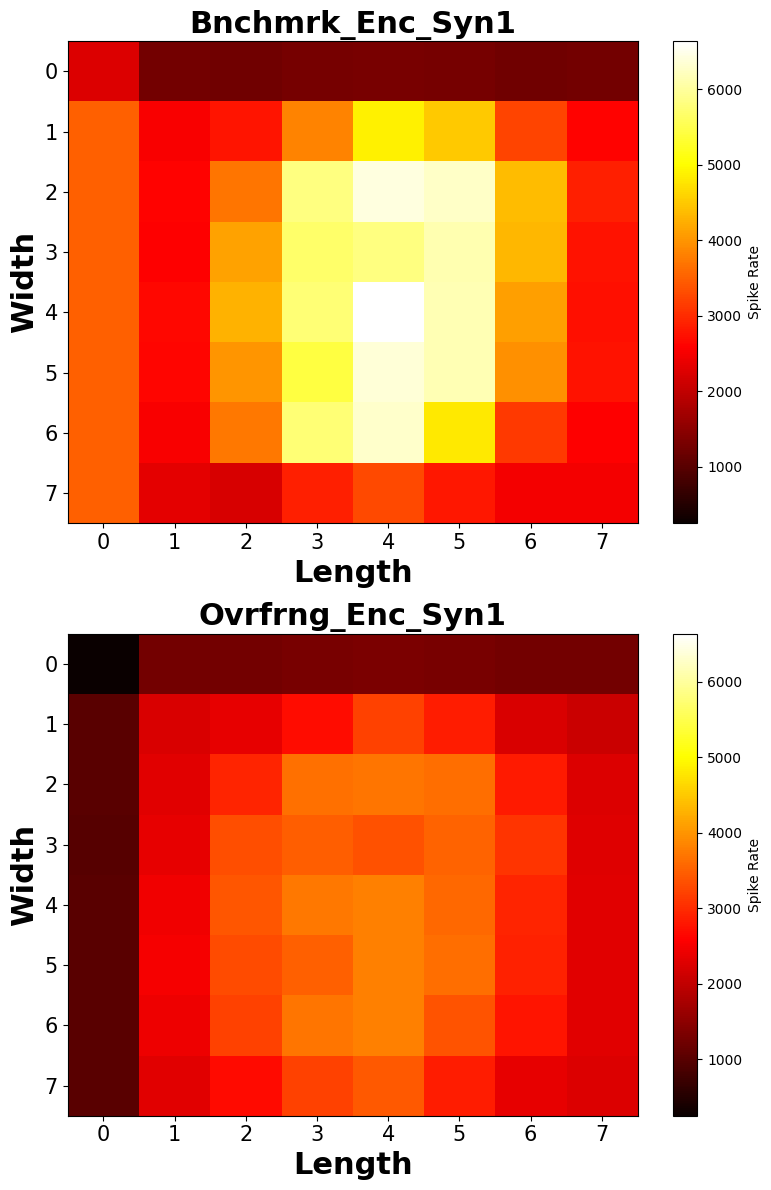

In [18]:

# shape = (250, 64, 8, 8)
# random_tensor = torch.randint(0, 2, size=shape)
# random_tensor2 = torch.randint(0, 2, size=shape)
# Bnchmrk_Enc_Syn1 = random_tensor.float()
# Ovrfrng_Enc_Syn1 = random_tensor2.float()

# print(Bnchmrk_Enc_Syn1.shape)
# print(Ovrfrng_Enc_Syn1.shape)
# # ///////////////////////////////////////////////////////
# Provides a global summary of activity, where we're aggregating the information from all neurons and all data points.
# This representation could be useful for capturing high-level, global features of data but might lose some spatial information.

# ----------------loading data to two files:
Bnchmrk_Enc_Syn1= epoch_activations[48]['Enc_syn1']
Ovrfrng_Enc_Syn1= epoch_activations_OverFiring[48]['Enc_syn1']
print("shape of Bnchmrk_Enc_Syn1", Bnchmrk_Enc_Syn1.shape)
print("shape of Ovrfrng_Enc_Syn1", Ovrfrng_Enc_Syn1.shape)



# -------------------------------------------------------------------


fig, axs = plt.subplots(2, 1, figsize=(8, 12))
font_size = 15
font = {'weight': 'bold', 'size': 22}


# Convert NumPy arrays to PyTorch tensors
Bnchmrk_Enc_Syn1 = torch.tensor(Bnchmrk_Enc_Syn1)
Ovrfrng_Enc_Syn1 = torch.tensor(Ovrfrng_Enc_Syn1)

Bnchmrk_Enc_Syn1 = torch.sum(Bnchmrk_Enc_Syn1, dim=(0, 1)).cpu().numpy() ## Calculate spike rates (sum along axis 0 and 1)
Ovrfrng_Enc_Syn1 = torch.sum(Ovrfrng_Enc_Syn1, dim=(0, 1)).cpu().numpy() ## Calculate spike rates (sum along axis 0 and 1)
print("shape of Bnchmrk_Enc_Syn1---- (sum along axis 2 and 3)", Bnchmrk_Enc_Syn1.shape)
print("shape of Ovrfrng_Enc_Syn1---- (sum along axis 2 and 3)", Ovrfrng_Enc_Syn1.shape)


# Calculate vmin and vmax for color scale based on the data
vmin = min(np.min(Bnchmrk_Enc_Syn1), np.min(Ovrfrng_Enc_Syn1))
vmax = max(np.max(Bnchmrk_Enc_Syn1), np.max(Ovrfrng_Enc_Syn1))

# Plot the spike rates for "activation["Enc_syn1"]"
axs[0].imshow(Bnchmrk_Enc_Syn1, cmap='hot', vmin=vmin, vmax=vmax, aspect='auto')
axs[0].set_title('Bnchmrk_Enc_Syn1', fontdict=font)
axs[0].set_xlabel('Length', fontweight="bold", fontdict=font)
axs[0].set_ylabel('Width', fontweight="bold", fontdict=font)
axs[0].tick_params(labelsize=font_size)
cbar1 = fig.colorbar(axs[0].imshow(Bnchmrk_Enc_Syn1, cmap='hot', vmin=vmin, vmax=vmax, aspect='auto'), ax=axs[0], orientation='vertical')
cbar1.set_label('Spike Rate')

# Plot the spike rates for "activation["Enc_syn1_ovrfrng"]"
axs[1].imshow(Ovrfrng_Enc_Syn1, cmap='hot', vmin=vmin, vmax=vmax, aspect='auto')
axs[1].set_title('Ovrfrng_Enc_Syn1', fontdict=font)
axs[1].set_xlabel('Length', fontweight="bold", fontdict=font)
axs[1].set_ylabel('Width', fontweight="bold", fontdict=font)
axs[1].tick_params(labelsize=font_size)
cbar2 = fig.colorbar(axs[1].imshow(Ovrfrng_Enc_Syn1, cmap='hot', vmin=vmin, vmax=vmax, aspect='auto'), ax=axs[1], orientation='vertical')
cbar2.set_label('Spike Rate')

plt.tight_layout()
plt.show()


# axs[0].get_figure().savefig('(Bnchmrk)vs(Ovrfrng)_Enc_Syn1_binary.pdf', format='pdf', bbox_inches='tight')


shape of Bnchmrk_Enc_Syn1 torch.Size([250, 64, 8, 8])
shape of Ovrfrng_Enc_Syn1 torch.Size([250, 64, 8, 8])


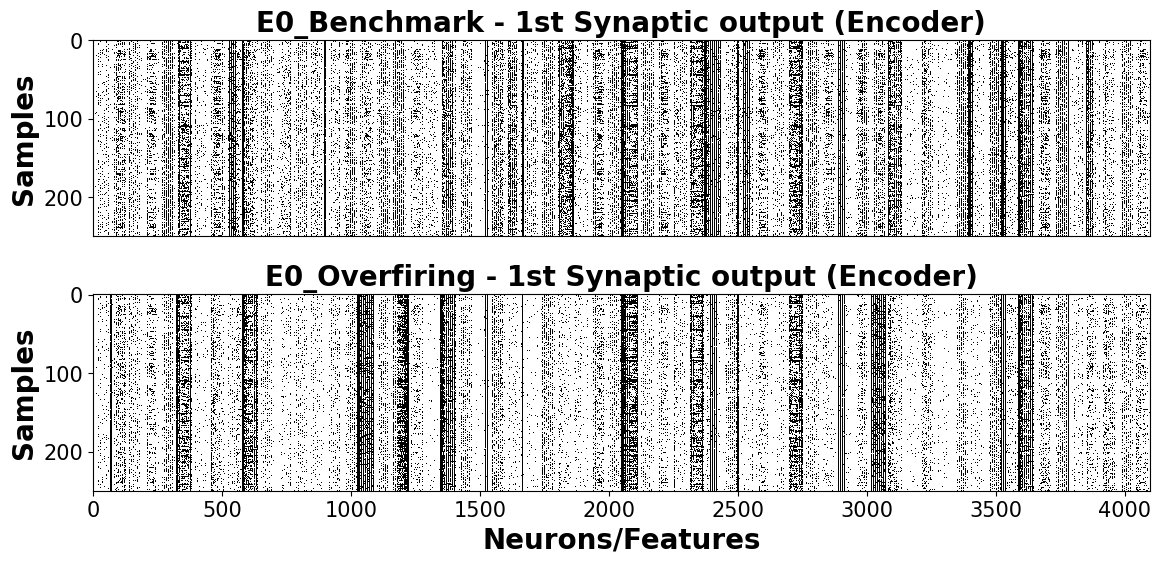

In [30]:

# ----------------loading data to two files:
Bnchmrk_Enc_Syn1= epoch_activations[48]['Enc_syn2']
Ovrfrng_Enc_Syn1= epoch_activations_OverFiring[48]['Enc_syn2']
print("shape of Bnchmrk_Enc_Syn1", Bnchmrk_Enc_Syn1.shape)
print("shape of Ovrfrng_Enc_Syn1", Ovrfrng_Enc_Syn1.shape)

# -----------------------
font_size = 15
font = {'weight': 'bold', 'size': 20}


# Flatten the tensors to have shape (num_samples, num_neurons)
Bnchmrk_Enc_Syn1_flat = Bnchmrk_Enc_Syn1.view(Bnchmrk_Enc_Syn1.shape[0], -1)
Ovrfrng_Enc_Syn1_flat = Ovrfrng_Enc_Syn1.view(Ovrfrng_Enc_Syn1.shape[0], -1)

# Create a binary raster plot
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.imshow(Bnchmrk_Enc_Syn1_flat.cpu(), cmap='binary', aspect='auto', interpolation='none')
plt.title('Benchmark - 1st Synaptic output (Encoder)', fontweight="bold", fontdict=font)
# plt.xlabel('Neurons/Features', fontweight="bold", fontdict=font)
plt.xticks([])  # Remove x-axis ticks
plt.ylabel('Samples', fontweight="bold", fontdict=font)
plt.tick_params(labelsize=font_size)

plt.subplot(2, 1, 2)
plt.imshow(Ovrfrng_Enc_Syn1_flat.cpu(), cmap='binary', aspect='auto', interpolation='none')
plt.title('Overfiring - 1st Synaptic output (Encoder)', fontweight="bold", fontdict=font)
plt.xlabel('Neurons/Features', fontweight="bold", fontdict=font)
plt.ylabel('Samples', fontweight="bold", fontdict=font)
plt.tick_params(labelsize=font_size)

plt.savefig('Rasterplot_(Bnchmrk)vs(Ovrfrng)_Enc_Syn2.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout(pad=2.0)  # Increase the padding between subplots

plt.show()

shape of Bnchmrk_Enc_Syn1 torch.Size([250, 64, 8, 8])
shape of Ovrfrng_Enc_Syn1 torch.Size([250, 64, 8, 8])
torch.Size([250, 4096])
torch.Size([1, 4096])


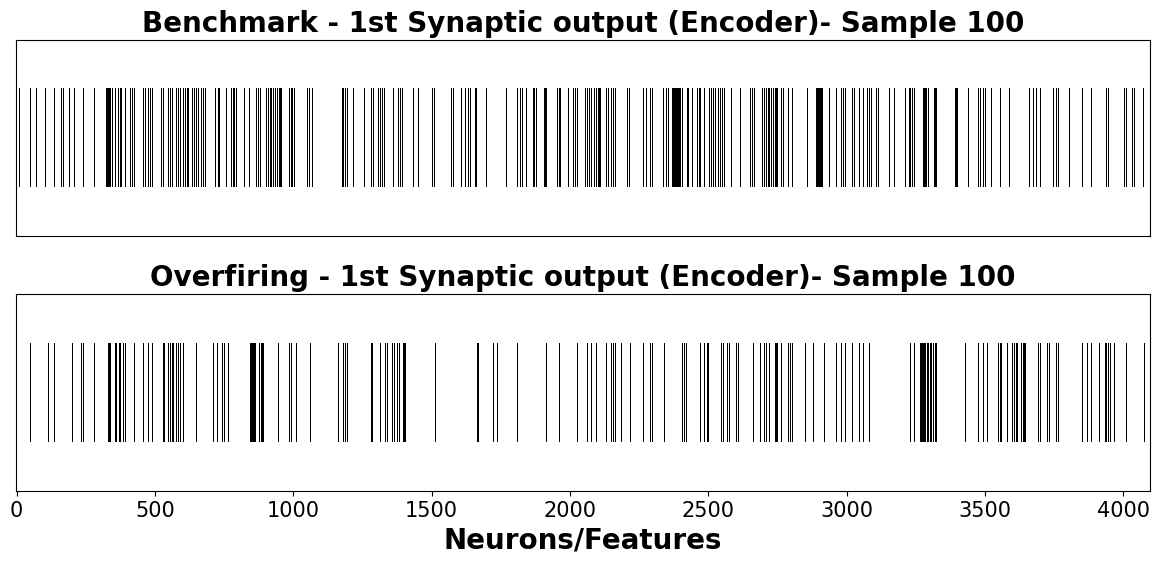

In [55]:

# ----------------loading data to two files:
Bnchmrk_Enc_Syn1= epoch_activations[48]['Enc_syn1']
Ovrfrng_Enc_Syn1= epoch_activations_OverFiring[48]['Enc_syn1']
print("shape of Bnchmrk_Enc_Syn1", Bnchmrk_Enc_Syn1.shape)
print("shape of Ovrfrng_Enc_Syn1", Ovrfrng_Enc_Syn1.shape)

# -----------------------
font_size = 15
font = {'weight': 'bold', 'size': 20}


# Flatten the tensors to have shape (num_samples, num_neurons)
Bnchmrk_Enc_Syn1_flat = Bnchmrk_Enc_Syn1.view(Bnchmrk_Enc_Syn1.shape[0], -1)
Ovrfrng_Enc_Syn1_flat = Ovrfrng_Enc_Syn1.view(Ovrfrng_Enc_Syn1.shape[0], -1)
print(Bnchmrk_Enc_Syn1_flat.shape)
print(Bnchmrk_Enc_Syn1_flat[100].unsqueeze(0).shape)
sample_index = 100  # Change this index to the sample you want to plot


# Create a binary raster plot
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.imshow(Bnchmrk_Enc_Syn1_flat[sample_index].unsqueeze(0).cpu(), cmap='binary', aspect='auto', interpolation='none')
plt.title('Benchmark - 1st Synaptic output (Encoder)- Sample {}'.format(sample_index) , fontweight="bold", fontdict=font)
# plt.xlabel('Neurons/Features', fontweight="bold", fontdict=font)
plt.xticks([])  # Remove x-axis ticks
# plt.ylabel('Samples', fontweight="bold", fontdict=font)
plt.yticks([])

plt.tick_params(labelsize=font_size)
plt.ylim(-1, 1)

plt.subplot(2, 1, 2)
plt.imshow(Ovrfrng_Enc_Syn1_flat[sample_index].unsqueeze(0).cpu(), cmap='binary', aspect='auto', interpolation='none')
plt.title('Overfiring - 1st Synaptic output (Encoder)- Sample {}'.format(sample_index), fontweight="bold", fontdict=font)
plt.xlabel('Neurons/Features', fontweight="bold", fontdict=font)
# plt.ylabel('Samples', fontweight="bold", fontdict=font)
plt.yticks([])
plt.tick_params(labelsize=font_size)
plt.ylim(-1, 1)

plt.savefig('Rasterplot_sample100_(Bnchmrk)vs(Ovrfrng)_Enc_Syn1.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout(pad=2.0)  # Increase the padding between subplots

plt.show()

shape of Bnchmrk_Enc_Syn1 torch.Size([250, 64, 8, 8])
shape of Ovrfrng_Enc_Syn1 torch.Size([250, 64, 8, 8])
torch.Size([250, 4096])
torch.Size([1, 4096])


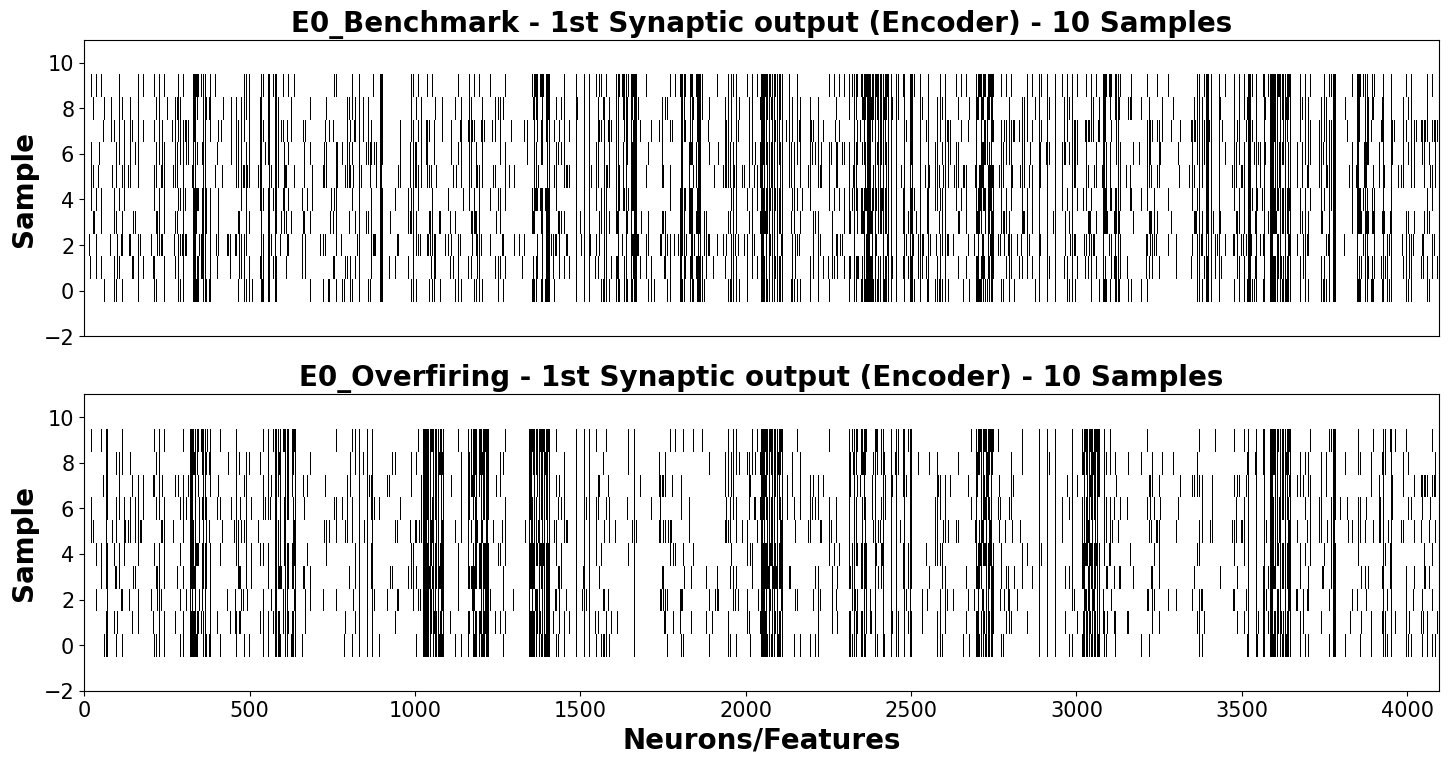

In [68]:
# Plot 10 samples

# ----------------loading data to two files:
Bnchmrk_Enc_Syn1= epoch_activations[0]['Enc_syn1']
Ovrfrng_Enc_Syn1= epoch_activations_OverFiring[0]['Enc_syn1']
print("shape of Bnchmrk_Enc_Syn1", Bnchmrk_Enc_Syn1.shape)
print("shape of Ovrfrng_Enc_Syn1", Ovrfrng_Enc_Syn1.shape)

# -----------------------
font_size = 15
font = {'weight': 'bold', 'size': 20}


# Flatten the tensors to have shape (num_samples, num_neurons)
Bnchmrk_Enc_Syn1_flat = Bnchmrk_Enc_Syn1.view(Bnchmrk_Enc_Syn1.shape[0], -1)
Ovrfrng_Enc_Syn1_flat = Ovrfrng_Enc_Syn1.view(Ovrfrng_Enc_Syn1.shape[0], -1)
print(Bnchmrk_Enc_Syn1_flat.shape)
print(Bnchmrk_Enc_Syn1_flat[100].unsqueeze(0).shape)

num_samples_to_plot = 10

# Create a binary raster plot
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.imshow(Bnchmrk_Enc_Syn1_flat[:num_samples_to_plot].cpu(), cmap='binary', aspect='auto', interpolation='none')
plt.title('E0_Benchmark - 1st Synaptic output (Encoder) - {} Samples'.format(num_samples_to_plot), fontweight="bold", fontdict=font)
# plt.xlabel('Neurons/Features', fontweight="bold", fontdict=font)
plt.xticks([])  # Remove x-axis ticks
plt.ylabel('Sample', fontweight="bold", fontdict=font)
plt.tick_params(labelsize=font_size)
# plt.ylim(-1, 10)
plt.ylim(-2, 11)
# plt.xlim(-20, 4120)


plt.subplot(2, 1, 2)
plt.imshow(Ovrfrng_Enc_Syn1_flat[:num_samples_to_plot].cpu(), cmap='binary', aspect='auto', interpolation='none')
plt.title('E0_Overfiring - 1st Synaptic output (Encoder) - {} Samples'.format(num_samples_to_plot), fontweight="bold", fontdict=font)
plt.xlabel('Neurons/Features', fontweight="bold", fontdict=font)–
plt.ylabel('Sample', fontweight="bold", fontdict=font)
plt.tick_params(labelsize=font_size)
plt.ylim(-2, 11)
# plt.ylim(-1, 10)

# plt.savefig('10Samples_E0_Rasterplot_(Bnchmrk)vs(Ovrfrng)_Enc_Syn1.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout(pad=2.0)  # Increase the padding between subplots

plt.show()




##  investigate how the spatial patterns of activity change, and how individual neurons are affected by overfiring

shape of Bnchmrk_Enc_Syn1 torch.Size([250, 64, 8, 8])
shape of Ovrfrng_Enc_Syn1 torch.Size([250, 64, 8, 8])
shape of Bnchmrk_Enc_Syn1---- (sum along axis 2 and 3) (250, 64)
shape of Ovrfrng_Enc_Syn1---- (sum along axis 2 and 3) (250, 64)


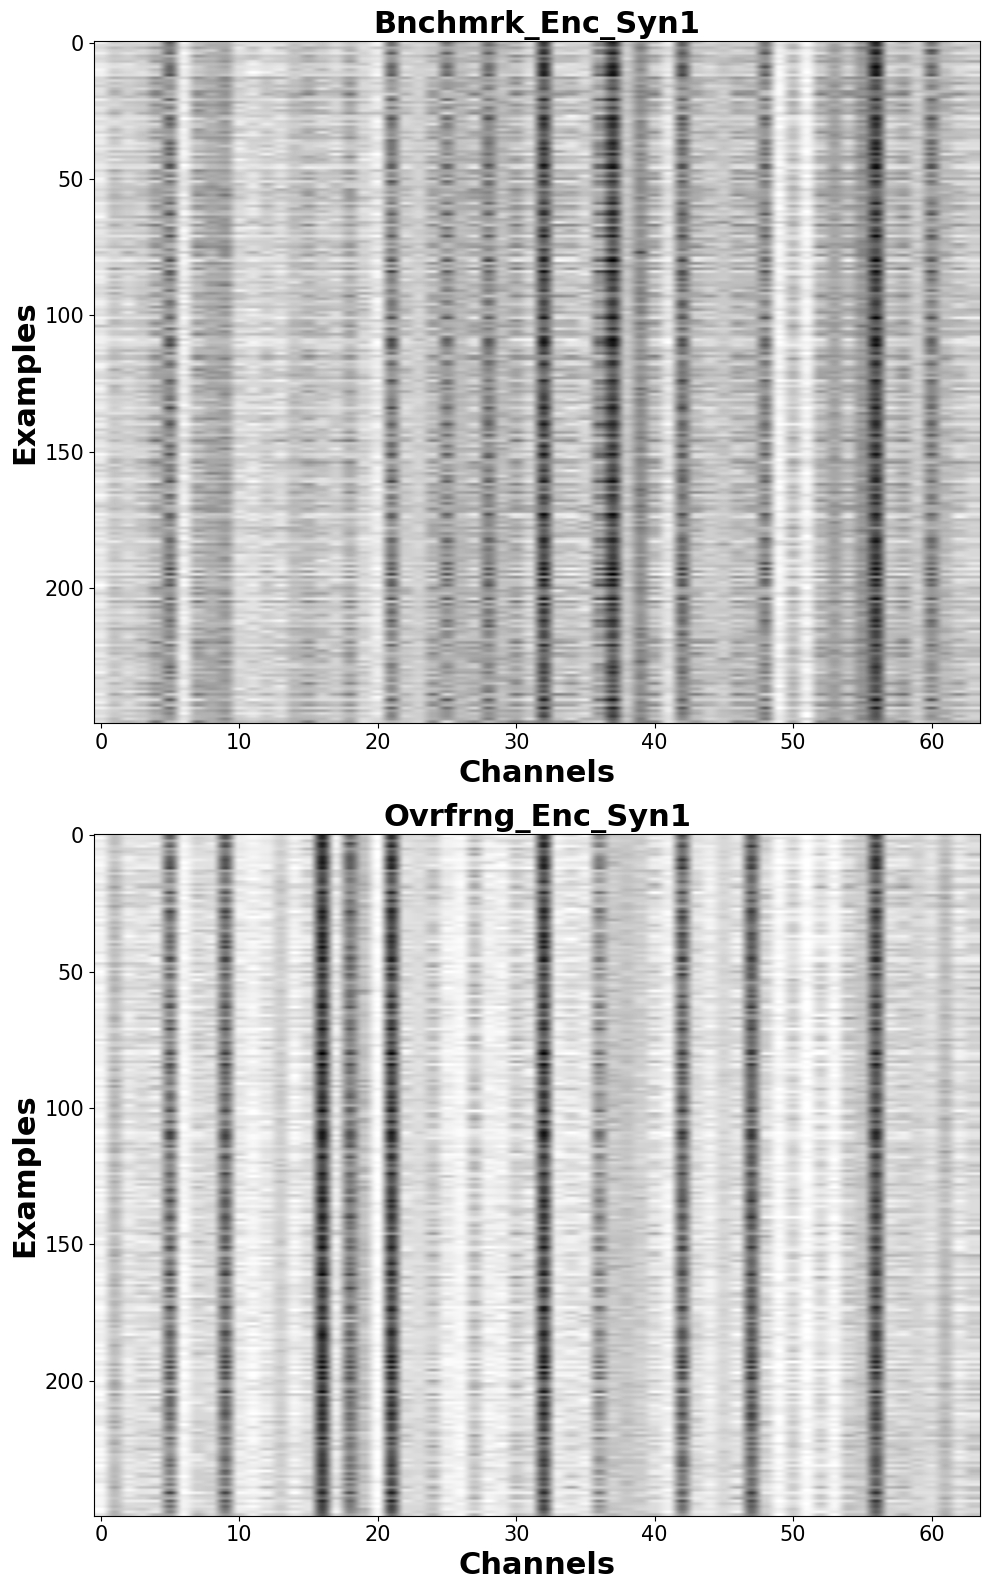

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 16))
font_size = 15
font = {'weight': 'bold', 'size': 22}


Bnchmrk_Enc_Syn1= epoch_activations[0]['Enc_syn1']
Ovrfrng_Enc_Syn1= epoch_activations_OverFiring[0]['Enc_syn1']
print("shape of Bnchmrk_Enc_Syn1", Bnchmrk_Enc_Syn1.shape)
print("shape of Ovrfrng_Enc_Syn1", Ovrfrng_Enc_Syn1.shape)

Bnchmrk_Enc_Syn1 = torch.sum(Bnchmrk_Enc_Syn1, dim=(2, 3)).cpu().numpy() ## Calculate spike rates (sum along axis 2 and 3)
Ovrfrng_Enc_Syn1 = torch.sum(Ovrfrng_Enc_Syn1, dim=(2, 3)).cpu().numpy() ## Calculate spike rates (sum along axis 2 and 3)
print("shape of Bnchmrk_Enc_Syn1---- (sum along axis 2 and 3)", Bnchmrk_Enc_Syn1.shape)
print("shape of Ovrfrng_Enc_Syn1---- (sum along axis 2 and 3)", Ovrfrng_Enc_Syn1.shape)



# Plot the spike rates for "activation["Enc_syn1"]"
axs[0].imshow(Bnchmrk_Enc_Syn1, cmap='binary', aspect='auto')
axs[0].set_title('Bnchmrk_Enc_Syn1', fontdict=font)
axs[0].set_xlabel('Channels', fontweight="bold", fontdict=font)
axs[0].set_ylabel('Examples', fontweight="bold", fontdict=font)
axs[0].tick_params(labelsize=font_size)
# cbar1 = fig.colorbar(axs[0].imshow(np.zeros_like(Bnchmrk_Enc_Syn1), cmap='hot'), ax=axs[0], orientation='vertical', aspect='auto')
# cbar1.set_label('Spike Rate')


# Plot the spike rates for "activation["Enc_syn1_ovrfrng"]"
axs[1].imshow(Ovrfrng_Enc_Syn1, cmap='binary', aspect='auto')
axs[1].set_title('Ovrfrng_Enc_Syn1', fontdict=font)
axs[1].set_xlabel('Channels', fontweight="bold", fontdict=font)
axs[1].set_ylabel('Examples', fontweight="bold", fontdict=font)
axs[1].tick_params(labelsize=font_size)
# cbar2 = fig.colorbar(axs[1].imshow(np.zeros_like(Ovrfrng_Enc_Syn1), cmap='hot'), ax=axs[1], orientation='vertical', aspect='auto')
# cbar2.set_label('Spike Rate')

plt.tight_layout()
plt.show()


# axs[0].get_figure().savefig('E0_(Bnchmrk)vs(Ovrfrng)_Enc_Syn1_binary.pdf', format='pdf', bbox_inches='tight')


# Decoder plotting:

shape of Bnchmrk torch.Size([250, 64, 8, 8])
shape of Ovrfrng torch.Size([250, 64, 8, 8])
shape of Bnchmrk---- (sum along axis 2 and 3) (250, 64)
shape of Ovrfrng---- (sum along axis 2 and 3) (250, 64)


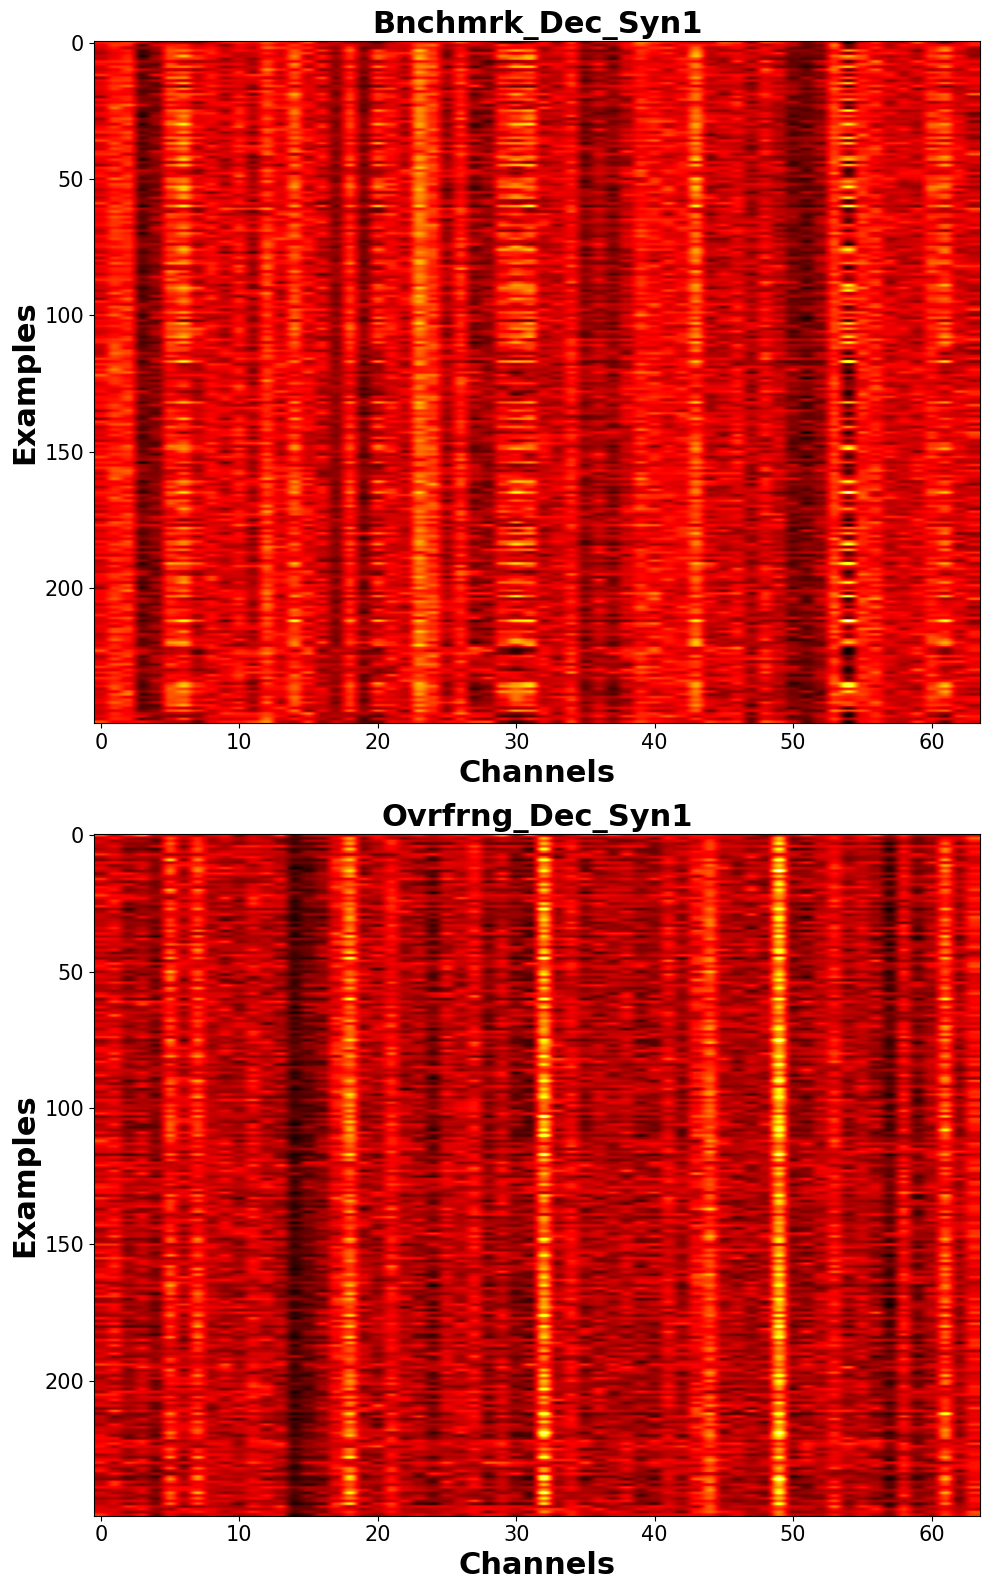

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 16))
font_size = 15
font = {'weight': 'bold', 'size': 22}


Bnchmrk= epoch_activations[48]['Dec_syn1']
Ovrfrng= epoch_activations_OverFiring[48]['Dec_syn1']
print("shape of Bnchmrk", Bnchmrk.shape)
print("shape of Ovrfrng", Ovrfrng.shape)

Bnchmrk = torch.sum(Bnchmrk, dim=(2, 3)).cpu().numpy() ## Calculate spike rates (sum along axis 2 and 3)
Ovrfrng = torch.sum(Ovrfrng, dim=(2, 3)).cpu().numpy() ## Calculate spike rates (sum along axis 2 and 3)
print("shape of Bnchmrk---- (sum along axis 2 and 3)", Bnchmrk.shape)
print("shape of Ovrfrng---- (sum along axis 2 and 3)", Ovrfrng.shape)



# Plot the spike rates for "activation["Enc_syn1"]"
axs[0].imshow(Bnchmrk, cmap='hot', aspect='auto')
axs[0].set_title('Bnchmrk_Dec_Syn1', fontdict=font)
axs[0].set_xlabel('Channels', fontweight="bold", fontdict=font)
axs[0].set_ylabel('Examples', fontweight="bold", fontdict=font)
axs[0].tick_params(labelsize=font_size)

# Plot the spike rates for "activation["Enc_syn1_ovrfrng"]"
axs[1].imshow(Ovrfrng, cmap='hot', aspect='auto')
axs[1].set_title('Ovrfrng_Dec_Syn1', fontdict=font)
axs[1].set_xlabel('Channels', fontweight="bold", fontdict=font)
axs[1].set_ylabel('Examples', fontweight="bold", fontdict=font)
axs[1].tick_params(labelsize=font_size)

# cbar1 = fig.colorbar(axs[0].imshow(np.zeros_like(Bnchmrk_Enc_Syn1), cmap='hot'), ax=axs[0], orientation='vertical', aspect='auto')
# cbar1.set_label('Spike Rate')

# cbar2 = fig.colorbar(axs[1].imshow(np.zeros_like(Ovrfrng_Enc_Syn1), cmap='hot'), ax=axs[1], orientation='vertical', aspect='auto')
# cbar2.set_label('Spike Rate')

plt.tight_layout()
plt.show()


axs[0].get_figure().savefig('(Bnchmrk)vs(Ovrfrng)_Dec_Syn1.pdf', format='pdf', bbox_inches='tight')


In [ ]:
# import numpy as np
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# # Assuming your tensor is named 'data' with shape (250, 64, 8, 8)
# # Reshape it to (250, 64*8*8) for PCA
# data_flattened = data.reshape(250, -1)

# # Apply PCA with desired number of components (e.g., 2 for 2D visualization)
# pca = PCA(n_components=2)
# reduced_data = pca.fit_transform(data_flattened)

# # Plot the reduced data
# plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
# plt.title('PCA Visualization')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()

# # import numpy as np
# # from sklearn.decomposition import PCA
# # import matplotlib.pyplot as plt
# # from mpl_toolkits.mplot3d import Axes3D

# # # Assuming your tensor is named 'data' with shape (250, 64, 8, 8)
# # # Reshape it to (250, 64*8*8) for PCA
# # data_flattened = data.reshape(250, -1)

# # # Apply PCA with 3 components for 3D visualization
# # pca = PCA(n_components=3)
# # reduced_data = pca.fit_transform(data_flattened)

# # # Create a 3D scatter plot
# # fig = plt.figure()
# # ax = fig.add_subplot(111, projection='3d')

# # # Plot the reduced data
# # ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2])
# # ax.set_title('3D PCA Visualization')
# # ax.set_xlabel('Principal Component 1')
# # ax.set_ylabel('Principal Component 2')
# # ax.set_zlabel('Principal Component 3')

# # plt.show()


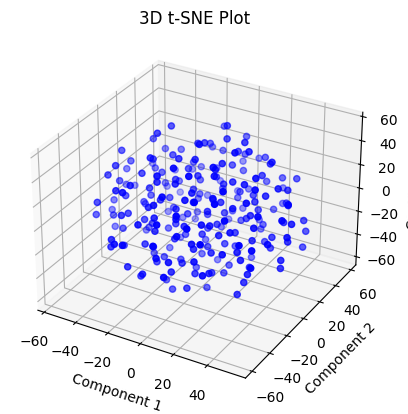

In [ ]:
# # import numpy as np
# # from sklearn.manifold import TSNE
# # import matplotlib.pyplot as plt


# # print(data.shape)
# # # Assuming your data is stored in a variable named 'data' with shape (250, 64, 8, 8)
# # # You may need to reshape the data if it's not already flattened
# # data = data.reshape((250, -1))

# # # Initialize the t-SNE model
# # tsne = TSNE(n_components=2, random_state=42)

# # # Fit and transform the data to 2D
# # data_2d = tsne.fit_transform(data)

# # # Create a scatter plot of the t-SNE results
# # plt.figure(figsize=(8, 6))
# # plt.scatter(data_2d[:, 0], data_2d[:, 1])
# # plt.title('t-SNE Plot')
# # plt.show()

# import numpy as np
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Assuming you have your data in a variable 'data' of shape (250, 64, 8, 8)
# # You need to reshape it to (250, 64*8*8) to use it with t-SNE
# data_reshaped = data.reshape((data.shape[0], -1))

# # Initialize t-SNE model with 3 components (for 3D plot)
# tsne = TSNE(n_components=3, random_state=42)

# # Fit and transform the data
# embedded_data = tsne.fit_transform(data_reshaped)

# # Create a 3D scatter plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Scatter plot
# ax.scatter(embedded_data[:, 0], embedded_data[:, 1], embedded_data[:, 2], c='b', marker='o')

# # Customize the plot
# ax.set_xlabel('Component 1')
# ax.set_ylabel('Component 2')
# ax.set_zlabel('Component 3')
# ax.set_title('3D t-SNE Plot')

# plt.show()


In [ ]:
# # Create a raster plot
# plt.figure(figsize=(10, 6))
# plt.imshow(flattened_data[0], cmap='gray', aspect='auto')
# # plt.imshow(flattened_data[0], cmap='viridis', aspect='auto')
# # plt.imshow(flattened_data[0], cmap='coolwarm', aspect='auto')

# plt.xlabel('Time Steps')
# plt.ylabel('Channels')
# plt.title('Raster Plot of Spike Data')
# plt.colorbar(label='Spike Activity (0 or 1)')
# plt.show()

# shape = (250, 64, 8, 8)
# random_tensor = torch.randint(0, 2, size=shape)
# data = random_tensor.float()
# print(data.shape)


# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111, projection='3d')

# # Extract the number of time steps and channels
# num_samples, num_channels, num_steps, _ = data.shape

# # Loop through channels
# for channel in range(num_channels):
#     # Extract spike activity for the channel
#     channel_spike_activity = data[0, channel].flatten()  # Assuming we're visualizing the first sample

#     # Find the time steps where spikes occurred (where values are 1)
#     spike_indices = np.where(channel_spike_activity == 1)[0]

#     # Create a scatter plot for this channel
#     ax.scatter(spike_indices, np.full_like(spike_indices, channel), np.ones_like(spike_indices) * channel, c='b', marker='|')

# # Set axis labels
# ax.set_xlabel('Time Steps')
# ax.set_ylabel('Channels')
# ax.set_zlabel('Spike Activity')
# ax.set_title('3D Raster Plot of Spike Data')

# plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# shape = (250, 64, 8, 8)
# random_tensor = torch.randint(0, 2, size=shape)
# data = random_tensor.float()
# flattened_data = data.reshape(250, 64, -1)
# print(data.shape)
# # Assuming your spike rates data is in a variable called 'spike_rates'
# # The shape of 'spike_rates' should be (250, 64) where 250 is the number of samples and 64 is the number of channels/neurons

# # Calculate the mean spike rate across samples
# mean_spike_rates = np.mean(data, axis=0)

# # Create a histogram to visualize the spike rates
# plt.figure(figsize=(10, 6))
# plt.hist(mean_spike_rates, bins=20, color='blue', alpha=0.7)
# plt.xlabel('Spike Rate')
# plt.ylabel('Number of Channels/Neurons')
# plt.title('Spike Rate Histogram')
# plt.grid(True)
# plt.show()


In [ ]:
# import matplotlib.pyplot as plt

# # Assuming your tensor is named 'data' with shape (250, 64, 8, 8)
# num_samples = data.shape[0]

# # Create a 5x5 grid of subplots
# fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# # Plot a random subset of the data
# import random
# for i in range(5):
#     for j in range(5):
#         sample_index = random.randint(0, num_samples - 1)
#         axes[i, j].imshow(data[sample_index, 0], cmap='viridis')  # Adjust cmap as needed
#         axes[i, j].axis('off')  # Turn off axes labels

# plt.subplots_adjust(wspace=0, hspace=0)
# plt.show()


In [ ]:

# # Get the sizes (shapes) of the loaded data
# size_epoch_activations = len(epoch_activations)  # If it's a dictionary
# size_epoch_activations_OverFiring = len(epoch_activations_OverFiring)  # If it's a dictionary

# # Print the sizes
# print("Size of epoch_activations:", size_epoch_activations)
# print("Size of epoch_activations_OverFiring:", size_epoch_activations_OverFiring)

# # If the values are NumPy arrays or PyTorch tensors, you can access their shapes
# if size_epoch_activations > 0:
#     sample_value_shape = epoch_activations[list(epoch_activations.keys())[0]].shape
#     print("Shape of a sample value in epoch_activations:", sample_value_shape)

# if size_epoch_activations_OverFiring > 0:
#     sample_value_shape_OverFiring = epoch_activations_OverFiring[list(epoch_activations_OverFiring.keys())[0]].shape
#     print("Shape of a sample value in epoch_activations_OverFiring:", sample_value_shape_OverFiring)

In [ ]:
# for epoch, activations in epoch_activations.items():
#     print(f"Epoch {epoch + 1}:")

#     for layer_name, activation_tensor in activations.items():
#         if activation_tensor is not None:
#             print(f"Layer: {layer_name}, Tensor Size: {activation_tensor.shape}")
#         else:
#             print(f"Layer: {layer_name}, Tensor is None")


In [ ]:
# for epoch, activations in epoch_activations_OverFiring.items():
#     print(f"Epoch {epoch + 1}:")

#     for layer_name, activation_tensor in activations.items():
#         if activation_tensor is not None:
#             print(f"Layer: {layer_name}, Tensor Size: {activation_tensor.shape}")
#         else:
#             print(f"Layer: {layer_name}, Tensor is None")


In [ ]:

# print("Enc_Lk1 size:",activation["Enc_Lk1"].size())
# print("Enc_syn1 size: --------------------- " , activation["Enc_syn1"].size())
# print("Enc_syn2 size:---------------------", activation["Enc_syn2"].size())
# print("Dec_Lk1 size:" ,activation["Dec_Lk1"].size())
# print("Dec_syn1 size:---------------------" ,activation["Dec_syn1"].size())
# print("Dec_syn2 size:---------------------" , activation["Dec_syn2"].size())
# print(len(activation["Dec_Lk2"]))
# # hook_names = ["Enc_Lk1", "Enc_syn1", "Enc_syn2", "Enc_Lk2", "Dec_Lk1", "Dec_syn1", "Dec_syn2", "Dec_Lk2"]


Enc_Lk1 size: torch.Size([250, 32, 16, 16])
Enc_syn1 size: ---------------------  torch.Size([250, 64, 8, 8])
Enc_syn2 size:--------------------- torch.Size([250, 128, 4, 4])
Dec_Lk1 size: torch.Size([250, 128, 4, 4])
Dec_syn1 size:--------------------- torch.Size([250, 64, 8, 8])
Dec_syn2 size:--------------------- torch.Size([250, 32, 16, 16])
2


In [ ]:
print('------------------------')
print(activation["Enc_syn1"].size())
print('------------------------')
activation["Enc_syn1"].view(activation["Enc_syn1"].size(0), -1).shape
# x=x.view(x.size(0), -1)


------------------------
torch.Size([250, 64, 8, 8])
------------------------


torch.Size([250, 4096])

In [ ]:
# spike_rates1 = np.sum(activation["Enc_syn1"], axis=(1, 2, 3))
# activation["Enc_syn1"]

In [ ]:
spikes_normal = activation["Enc_syn1"]
print(spikes_normal.shape)
spike_rates_normal = torch.sum(spikes_normal, dim=(2, 3)).cpu().numpy() ## Calculate spike rates (sum along axis 2 and 3)

spike_rates_normal.shape

torch.Size([250, 32, 16, 16])


(250, 32)

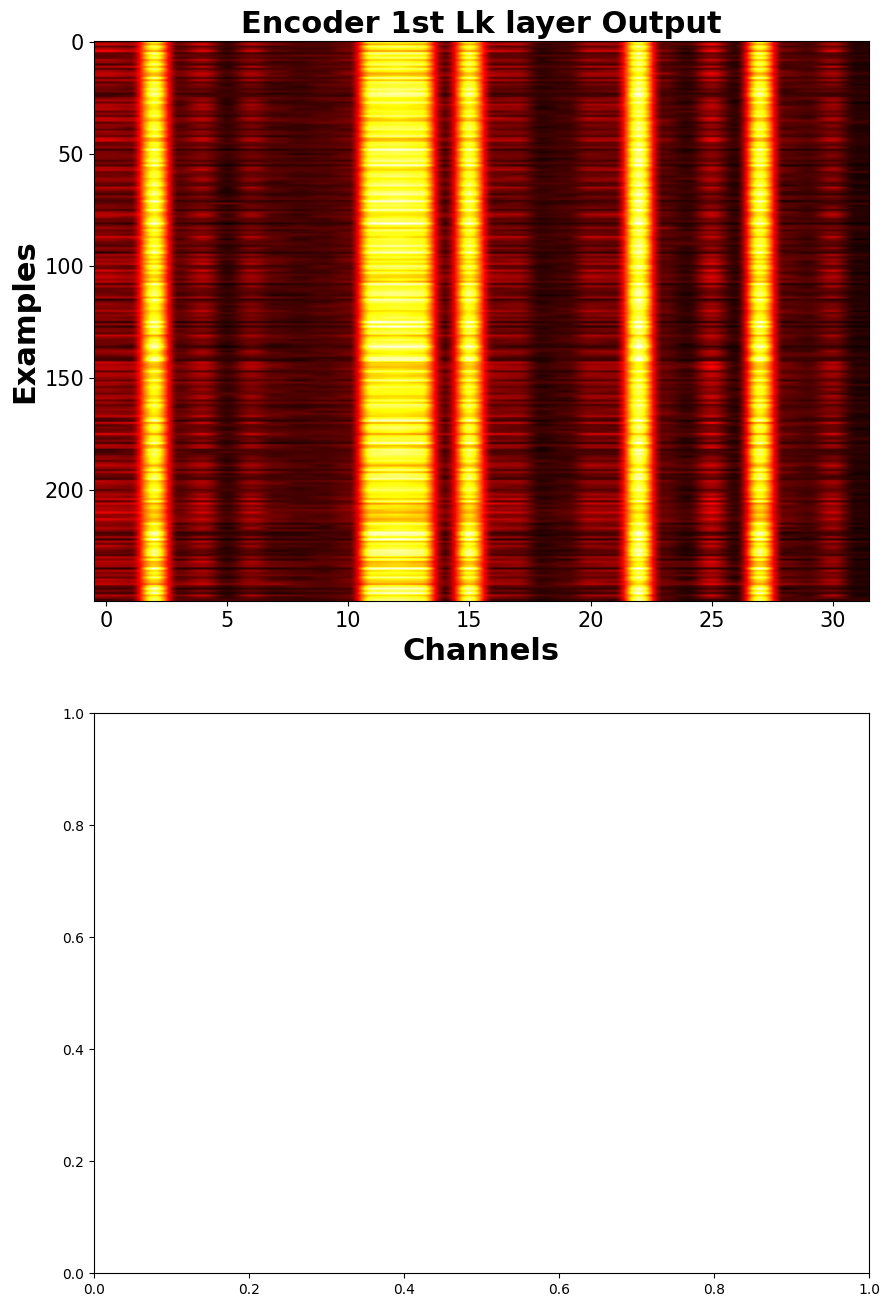